# Image classification of cardiomyocyte tissues

This pipeline classifies cardiomyocyte images to distinguish issues from patients with chronic heart failure from ones from health donnors. It builds an image classifier using a `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. The images downloaded from https://idr.openmicroscopy.org/webclient/?show=project-402 processed with the following:

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model.
* _Overfitting_ —How to identify and prevent it.
* _Data augmentation_ and _dropout_ —Key techniques to fight overfitting in computer vision tasks to incorporate into the data pipeline and image classifier model.

This pipeline follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import packages

It is always a good idea to import packages separately to minimise their impact on compatibility.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

Import Tensorflow and the Keras classes needed to construct our model.

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Load data

Download the dataset idr0042 with the OMERO 5.6.1 JSON API https://docs.openmicroscopy.org/omero/5.6.1/developers/json-api.html. The dataset is stored in the "/tmp/" directory for training and verification.

In [4]:
################################
# Create a session to access IDR
################################
import requests


def get_session() -> requests.Session:
    IDR_BASE_URL = "https://idr.openmicroscopy.org"
    INDEX_PAGE = "%s/webclient/?experimenter=-1" % IDR_BASE_URL

    # create http session
    with requests.Session() as session:
        request = requests.Request('GET', INDEX_PAGE)
        prepped = session.prepare_request(request)
        response = session.send(prepped)
        if response.status_code != 200:
            response.raise_for_status()
    return session

In [5]:
######################
# Access test data set
######################
# import json
# from IPython.display import display, HTML
import os
import tensorflow as tf

OUTPUT_PATH = '/tmp'


def download_img(ds_id: str, session: requests.Session, output_path: str = OUTPUT_PATH):
    IDR_BASE_URL = "https://idr.openmicroscopy.org"
    DS_IMG_URI = "{base}/api/v0/m/datasets/{dataset_id}/images/?limit=2500"         # test 1155, training 1144
    IMG_RDR_URI = "{base}/webgateway/render_image/{image_id}/0/0/"
    IMG_ANNO_URI = "{base}/webclient/api/annotations/?type=map&{type}={image_id}"

    qs_ds = {'base': IDR_BASE_URL, 'dataset_id': ds_id}
    r = session.get(DS_IMG_URI.format(**qs_ds))
    # print('HTTP status for image:', r.status_code)
    if r.status_code == 200:
        #     print (json.dumps(r.json()['data'][:1], indent=2, sort_keys=True))
        for img in r.json()['data']:    # [:2]:
            img_name = img['Name']
            img_id = img['@id']
            img_path = ''

            qs_img = {'base': IDR_BASE_URL, 'image_id': img_id}
            # display(HTML("<img src='%s' />" % IMG_RDR_URI.format(**qs_img)))

            qs_anno = {'base': IDR_BASE_URL, 'type': 'image', 'image_id': img_id}
            r_anno = session.get(IMG_ANNO_URI.format(**qs_anno))
            # print('HTTP status for annotation:', r_anno.status_code)
            for a in r_anno.json()['annotations']:
                for v in a['values']:
                    key = v[0]
                    value = v[1]
                    print(key, ':', value)

                    if key == 'Diagnosis' and value != 'heart tissue pathology':
                        path = os.path.join(output_path, value.replace(" ", "_"))
                        if not os.path.exists(path):
                            os.system("mkdir -p " + path)
                        img_path = tf.keras.utils.get_file(fname=os.path.join(path, img_name), origin=IMG_RDR_URI.format(**qs_img))
            print(img_name, img_id, img_path)
            print('')       # pretty print
    return output_path


# dataset IDs
DS_TEST_ID = "827"
DS_TRAIN_ID = "828"

validation_dir: str = download_img(ds_id=DS_TEST_ID, session=get_session(), output_path=os.path.join(OUTPUT_PATH, 'validation'))
train_dir: str = download_img(ds_id=DS_TRAIN_ID, session=get_session(), output_path=os.path.join(OUTPUT_PATH, 'train'))

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 33375
Clinical History : non-ischemic cardiomyopathy
33375_0_fal_1_0.png 3428066 /tmp/validation/chronic_heart_failure/33375_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 33375
Clinical History : non-ischemic cardiomyopathy
33375_0_fal_20_0.png 3428067 /tmp/validation/chronic_heart_failure/33375_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 33375
Clinical History : non-ischemic cardiomyopathy
33375_0_fal_23_0.png 3428068 /tmp/validation/chronic_heart_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33388
Clinical History : ischemic cardiomyopathy
33388_0_fal_13_0.png 3428089 /tmp/validation/chronic_heart_failure/33388_0_fal_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33388
Clinical History : ischemic cardiomyopathy
33388_0_fal_14_0.png 3428090 /tmp/validation/chronic_heart_failure/33388_0_fal_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33388
Clinical History : ischemic cardiomyopathy
33388_0_fal_15_0.png 3428091 /tmp/validati

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 62 years
Individual : 33394
Clinical History : ischemic cardiomyopathy
33394_0_fal_31_0.png 3428114 /tmp/validation/chronic_heart_failure/33394_0_fal_31_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 62 years
Individual : 33394
Clinical History : ischemic cardiomyopathy
33394_0_fal_33_0.png 3428115 /tmp/validation/chronic_heart_failure/33394_0_fal_33_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 62 years
Individual : 33394
Clinical History : ischemic cardiomyopathy
33394_0_fal_38_0.png 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 64 years
Individual : 33400
Clinical History : ischemic cardiomyopathy
33400_0_fal_24_0.png 3428137 /tmp/validation/chronic_heart_failure/33400_0_fal_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 64 years
Individual : 33400
Clinical History : ischemic cardiomyopathy
33400_0_fal_25_0.png 3428138 /tmp/validation/chronic_heart_failure/33400_0_fal_25_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 64 years
Individual : 33400
Clinical History : ischemic cardiomyopathy
33400_0_fal_27_0.png 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 42 years
Individual : 33402
Clinical History : ischemic cardiomyopathy
33402_0_fal_23_0.png 3428161 /tmp/validation/chronic_heart_failure/33402_0_fal_23_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 42 years
Individual : 33402
Clinical History : ischemic cardiomyopathy
33402_0_fal_24_0.png 3428162 /tmp/validation/chronic_heart_failure/33402_0_fal_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 42 years
Individual : 33402
Clinical History : ischemic cardiomyopathy
334

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33407
Clinical History : non-ischemic cardiomyopathy
33407_0_fal_6_0.png 3428186 /tmp/validation/chronic_heart_failure/33407_0_fal_6_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 33408
Clinical History : non-ischemic cardiomyopathy
33408_0_fal_10_0.png 3428187 /tmp/validation/chronic_heart_failure/33408_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 33408
Clinical History : non-ischemic cardiomyopathy
33408_0_fal_1_0.png 3428191 /tmp/validation/chronic_heart_f

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 60 years
Individual : 33414
Clinical History : ischemic cardiomyopathy
33414_0_fal_11_0.png 3428209 /tmp/validation/chronic_heart_failure/33414_0_fal_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 60 years
Individual : 33414
Clinical History : ischemic cardiomyopathy
33414_0_fal_13_0.png 3428210 /tmp/validation/chronic_heart_failure/33414_0_fal_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 60 years
Individual : 33414
Clinical History : ischemic cardiomyopathy
33414_0_fal_24_0.png 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33417
Clinical History : non-ischemic cardiomyopathy
33417_0_fal_24_0.png 3428234 /tmp/validation/chronic_heart_failure/33417_0_fal_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33417
Clinical History : non-ischemic cardiomyopathy
33417_0_fal_29_0.png 3428235 /tmp/validation/chronic_heart_failure/33417_0_fal_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33417
Clinical History : non-ischemic cardiomyopathy
33417_0_fal_39_0.p

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 71 years
Individual : 33423
Clinical History : non-ischemic cardiomyopathy
33423_0_fal_14_0.png 3428257 /tmp/validation/chronic_heart_failure/33423_0_fal_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 71 years
Individual : 33423
Clinical History : non-ischemic cardiomyopathy
33423_0_fal_15_0.png 3428258 /tmp/validation/chronic_heart_failure/33423_0_fal_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 71 years
Individual : 33423
Clinical History : non-ischemic cardiomyopathy
33423_0_fal_16_0.png 3428259 /tmp/validation/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33466
Clinical History : ischemic cardiomyopathy
33466_0_fal_3_0.png 3428283 /tmp/validation/chronic_heart_failure/33466_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33466
Clinical History : ischemic cardiomyopathy
33466_0_fal_46_0.png 3428284 /tmp/validation/chronic_heart_failure/33466_0_fal_46_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33466
Clinical History : ischemic cardiomyopathy
33466_0_fal_7_0.png 3428285 /tmp/validation/

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 41 years
Individual : 33468
Clinical History : ischemic cardiomyopathy
33468_0_fal_8_0.png 3428307 /tmp/validation/chronic_heart_failure/33468_0_fal_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 33472
Clinical History : non-ischemic cardiomyopathy
33472_0_fal_10_0.png 3428308 /tmp/validation/chronic_heart_failure/33472_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 33472
Clinical History : non-ischemic cardiomyopathy
33472_0_fal_1_0.png 3428313 /tmp/validati

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 28 years
Individual : 33477
Clinical History : non-ischemic cardiomyopathy
33477_0_fal_19_0.png 3428331 /tmp/validation/chronic_heart_failure/33477_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 28 years
Individual : 33477
Clinical History : non-ischemic cardiomyopathy
33477_0_fal_20_0.png 3428332 /tmp/validation/chronic_heart_failure/33477_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 28 years
Individual : 33477
Clinical History : non-ischemic cardiomyopathy
33477_0_fal_23_0.png 3428333 /tmp/validation/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 68 years
Individual : 33482
Clinical History : ischemic cardiomyopathy
33482_0_fal_12_0.png 3428354 /tmp/validation/chronic_heart_failure/33482_0_fal_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 68 years
Individual : 33482
Clinical History : ischemic cardiomyopathy
33482_0_fal_13_0.png 3428355 /tmp/validation/chronic_heart_failure/33482_0_fal_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 68 years
Individual : 33482
Clinical History : ischemic cardiomyopathy
33482_0_fal_14_0.png 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33490
Clinical History : non-ischemic cardiomyopathy
33490_0_fal_24_0.png 3428379 /tmp/validation/chronic_heart_failure/33490_0_fal_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33490
Clinical History : non-ischemic cardiomyopathy
33490_0_fal_30_0.png 3428380 /tmp/validation/chronic_heart_failure/33490_0_fal_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33490
Clinical History : non-ischemic cardiomyopathy
33490_0_fal_34_0.png 3428381 /tmp/validation/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 68 years
Individual : 33538
Clinical History : ischemic cardiomyopathy
33538_0_fal_27_0.png 3428402 /tmp/validation/chronic_heart_failure/33538_0_fal_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 68 years
Individual : 33538
Clinical History : ischemic cardiomyopathy
33538_0_fal_36_0.png 3428404 /tmp/validation/chronic_heart_failure/33538_0_fal_36_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 68 years
Individual : 33538
Clinical History : ischemic cardiomyopathy
335

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 57 years
Individual : 33542
Clinical History : non-ischemic cardiomyopathy
33542_0_fal_20_0.png 3428427 /tmp/validation/chronic_heart_failure/33542_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 57 years
Individual : 33542
Clinical History : non-ischemic cardiomyopathy
33542_0_fal_2_0.png 3428428 /tmp/validation/chronic_heart_failure/33542_0_fal_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33545
Clinical History : ischemic cardiomyopathy
33545_0_fal_15_0.png 3428429 /tmp/valida

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 31 years
Individual : 33548
Clinical History : non-ischemic cardiomyopathy
33548_0_fal_14_0.png 3428451 /tmp/validation/chronic_heart_failure/33548_0_fal_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 31 years
Individual : 33548
Clinical History : non-ischemic cardiomyopathy
33548_0_fal_15_0.png 3428452 /tmp/validation/chronic_heart_failure/33548_0_fal_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 31 years
Individual : 33548
Clinical History : non-ischemic cardiomyopathy
33548_0_fal_17_0.p

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 52 years
Individual : 33556
Clinical History : ischemic cardiomyopathy
33556_0_fal_21_0.png 3428474 /tmp/validation/chronic_heart_failure/33556_0_fal_21_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 52 years
Individual : 33556
Clinical History : ischemic cardiomyopathy
33556_0_fal_3_0.png 3428478 /tmp/validation/chronic_heart_failure/33556_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 52 years
Individual : 33556
Clinical History : ischemic cardiomyopathy
33556_0_fal_32_0.png 34

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 62 years
Individual : 34073
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34073_1_nrm_13_0.png 3428498 /tmp/validation/not_chronic_heart_failure/34073_1_nrm_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 62 years
Individual : 34073
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34073_1_nrm_14_0.png 3428499 /tmp/validation/not_chronic_heart_failure/34073_1_nrm_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 62 y

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 19 years
Individual : 34076
Clinical History : non-ischemic cardiomyopathy
34076_0_fal_26_0.png 3428522 /tmp/validation/chronic_heart_failure/34076_0_fal_26_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 19 years
Individual : 34076
Clinical History : non-ischemic cardiomyopathy
34076_0_fal_29_0.png 3428523 /tmp/validation/chronic_heart_failure/34076_0_fal_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 19 years
Individual : 34076
Clinical History : non-ischemic cardiomyopathy
34076_0_fal_40_0.png 3428524 /tmp/validation/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Unknown racial group
Age : 46 years
Individual : 34083
Clinical History : non-ischemic cardiomyopathy
34083_0_fal_19_0.png 3428546 /tmp/validation/chronic_heart_failure/34083_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Unknown racial group
Age : 46 years
Individual : 34083
Clinical History : non-ischemic cardiomyopathy
34083_0_fal_20_0.png 3428547 /tmp/validation/chronic_heart_failure/34083_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Unknown racial group
Age : 46 years
Individual : 34083
Clinical History : non-ischemic cardiomyopathy
34083_0_fal_2_0.png 3428

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 34086
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34086_1_nrm_2_0.png 3428571 /tmp/validation/not_chronic_heart_failure/34086_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 34086
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34086_1_nrm_21_0.png 3428569 /tmp/validation/not_chronic_heart_failure/34086_1_nrm_21_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 34086
Clinical Hi

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 34089
Clinical History : non-ischemic cardiomyopathy
34089_0_fal_22_0.png 3428592 /tmp/validation/chronic_heart_failure/34089_0_fal_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 34090
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34090_1_nrm_1_0.png 3428602 /tmp/validation/not_chronic_heart_failure/34090_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 34090
Clinical History : donor without a history of chronic heart failure bu

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Race not stated
Age : 61 years
Individual : 34231
Clinical History : non-ischemic cardiomyopathy
34231_0_fal_10_0.png 3428616 /tmp/validation/chronic_heart_failure/34231_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Race not stated
Age : 61 years
Individual : 34231
Clinical History : non-ischemic cardiomyopathy
34231_0_fal_1_0.png 3428620 /tmp/validation/chronic_heart_failure/34231_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Race not stated
Age : 61 years
Individual : 34231
Clinical History : non-ischemic cardiomyopathy
34231_0_fal_13_0.png 3428617 /tmp/v

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34281
Clinical History : no documentation of ischemic vs non-ischemic etiology
34281_0_fal_12_0.png 3428639 /tmp/validation/chronic_heart_failure/34281_0_fal_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34281
Clinical History : no documentation of ischemic vs non-ischemic etiology
34281_0_fal_14_0.png 3428640 /tmp/validation/chronic_heart_failure/34281_0_fal_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34281
Clinical History : no documentation of ischemic vs non-ischemic etiology
34281_0_fal_15_0.png 3428641 /tmp/validation/chronic_heart_failure/34281_0_fal

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 44 years
Individual : 35589
Clinical History : normal cardiovascular function by cardiac catheterization
35589_1_nrm_27_0.png 3428664 /tmp/validation/not_chronic_heart_failure/35589_1_nrm_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 44 years
Individual : 35589
Clinical History : normal cardiovascular function by cardiac catheterization
35589_1_nrm_32_0.png 3428665 /tmp/validation/not_chronic_heart_failure/35589_1_nrm_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 44 years
Individual : 35589
Clinical History : normal cardiovascular function by cardiac catheterization
35589_1_nrm_35_0.png 3428

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 69 years
Individual : 35592
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35592_1_nrm_27_0.png 3428685 /tmp/validation/not_chronic_heart_failure/35592_1_nrm_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 69 years
Individual : 35592
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35592_1_nrm_3_0.png 3428688 /tmp/validation/not_chronic_heart_failure/35592_1_nrm_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 69 years
Individual : 35592
Clinical Histo

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 73 years
Individual : 35597
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35597_1_nrm_3_0.png 3428712 /tmp/validation/not_chronic_heart_failure/35597_1_nrm_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 73 years
Individual : 35597
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35597_1_nrm_33_0.png 3428709 /tmp/validation/not_chronic_heart_failure/35597_1_nrm_33_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 73 years
Individua

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 53 years
Individual : 35601
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35601_1_nrm_3_0.png 3428732 /tmp/validation/not_chronic_heart_failure/35601_1_nrm_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 53 years
Individual : 35601
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35601_1_nrm_37_0.png 3428731 /tmp/validation/not_chronic_heart_failure/35601_1_nrm_37_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 53 years
Individual : 35

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35603
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35603_1_nrm_18_0.png 3428751 /tmp/validation/not_chronic_heart_failure/35603_1_nrm_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35603
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35603_1_nrm_23_0.png 3428753 /tmp/validation/not_chronic_heart_failure/35603_1_nrm_23_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35603
Clinical 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 80 years
Individual : 35607
Clinical History : normal cardiovascular function by cardiac catheterization
35607_1_nrm_27_0.png 3428775 /tmp/validation/not_chronic_heart_failure/35607_1_nrm_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 80 years
Individual : 35607
Clinical History : normal cardiovascular function by cardiac catheterization
35607_1_nrm_3_0.png 3428778 /tmp/validation/not_chronic_heart_failure/35607_1_nrm_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 80 years
Individual : 35607
Clinical History : normal cardiovascular function by cardiac catheterization
35607_1_nrm_31_0.png 3428776 /tmp/validati

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 35622
Clinical History : normal cardiovascular function by cardiac catheterization
35622_1_nrm_43_0.png 3428800 /tmp/validation/not_chronic_heart_failure/35622_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 35622
Clinical History : normal cardiovascular function by cardiac catheterization
35622_1_nrm_7_0.png 3428801 /tmp/validation/not_chronic_heart_failure/35622_1_nrm_7_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 35622
Clinical History : normal cardiovascular function by cardiac catheterization
35622_1_nrm_9_0.png 3428802 /tmp/validatio

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35626
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35626_1_nrm_19_0.png 3428821 /tmp/validation/not_chronic_heart_failure/35626_1_nrm_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35626
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35626_1_nrm_20_0.png 3428823 /tmp/validation/not_chronic_heart_failure/35626_1_nrm_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35626
Clinical 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 51 years
Individual : 35629
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35629_1_nrm_42_0.png 3428844 /tmp/validation/not_chronic_heart_failure/35629_1_nrm_42_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 51 years
Individual : 35629
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35629_1_nrm_48_0.png 3428845 /tmp/validation/not_chronic_heart_failure/35629_1_nrm_48_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 51 years
Individual : 35629
Clinical History :

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 35632
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35632_1_nrm_7_0.png 3428867 /tmp/validation/not_chronic_heart_failure/35632_1_nrm_7_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 35632
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35632_1_nrm_9_0.png 3428868 /tmp/validation/not_chronic_heart_failure/35632_1_nrm_9_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 35635
Clinical History : 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 37 years
Individual : 35638
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35638_1_nrm_3_0.png 3428895 /tmp/validation/not_chronic_heart_failure/35638_1_nrm_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 37 years
Individual : 35638
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35638_1_nrm_34_0.png 3428892 /tmp/validation/not_chronic_heart_failure/35638_1_nrm_34_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 37 years
Individual : 35638
Clinical Histo

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 50 years
Individual : 35644
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35644_1_nrm_11_0.png 3428913 /tmp/validation/not_chronic_heart_failure/35644_1_nrm_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 50 years
Individual : 35644
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35644_1_nrm_12_0.png 3428914 /tmp/validation/not_chronic_heart_failure/35644_1_nrm_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 50 years
Individual : 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 48 years
Individual : 35649
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35649_1_nrm_29_0.png 3428936 /tmp/validation/not_chronic_heart_failure/35649_1_nrm_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 48 years
Individual : 35649
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35649_1_nrm_3_0.png 3428940 /tmp/validation/not_chronic_heart_failure/35649_1_nrm_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 48 years
Individual : 35

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 50 years
Individual : 35651
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35651_1_nrm_9_0.png 3428956 /tmp/validation/not_chronic_heart_failure/35651_1_nrm_9_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 35878
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35878_1_nrm_10_0.png 3428957 /tmp/validation/not_chronic_heart_failure/35878_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 35878
Clinical

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 35880
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35880_1_nrm_19_0.png 3428976 /tmp/validation/not_chronic_heart_failure/35880_1_nrm_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 35880
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35880_1_nrm_20_0.png 3428978 /tmp/validation/not_chronic_heart_failure/35880_1_nrm_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 36109
Clinical Histor

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 21 years
Individual : 36114
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36114_1_nrm_8_0.png 3428999 /tmp/validation/not_chronic_heart_failure/36114_1_nrm_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 21 years
Individual : 36114
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36114_1_nrm_9_0.png 3429000 /tmp/validation/not_chronic_heart_failure/36114_1_nrm_9_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36116
Clinical Hist

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 26 years
Individual : 36117
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36117_1_nrm_47_0.png 3429020 /tmp/validation/not_chronic_heart_failure/36117_1_nrm_47_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 26 years
Individual : 36117
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36117_1_nrm_8_0.png 3429022 /tmp/validation/not_chronic_heart_failure/36117_1_nrm_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 78 years
Individual : 36121
Clinical Hi

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 36123
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36123_1_nrm_53_0.png 3429042 /tmp/validation/not_chronic_heart_failure/36123_1_nrm_53_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 36123
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36123_1_nrm_55_0.png 3429043 /tmp/validation/not_chronic_heart_failure/36123_1_nrm_55_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 36123
Clinical 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 77 years
Individual : 36135
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36135_1_nrm_39_0.png 3429064 /tmp/validation/not_chronic_heart_failure/36135_1_nrm_39_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 77 years
Individual : 36135
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36135_1_nrm_46_0.png 3429065 /tmp/validation/not_chronic_heart_failure/36135_1_nrm_46_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American


Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 33383
Clinical History : ischemic cardiomyopathy
33383_0_fal_11_0.png 3429617 /tmp/train/chronic_heart_failure/33383_0_fal_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 33383
Clinical History : ischemic cardiomyopathy
33383_0_fal_13_0.png 3429618 /tmp/train/chronic_heart_failure/33383_0_fal_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 33383
Clinical History : ischemic cardiomyopathy
33383_0_fal_17_0.png 3429619 /tmp/train/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 65 years
Individual : 33387
Clinical History : ischemic cardiomyopathy
33387_0_fal_2_0.png 3429634 /tmp/train/chronic_heart_failure/33387_0_fal_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 65 years
Individual : 33387
Clinical History : ischemic cardiomyopathy
33387_0_fal_21_0.png 3429631 /tmp/train/chronic_heart_failure/33387_0_fal_21_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 65 years
Individual : 33387
Clinical History : ischemic cardiomyopathy
33387_0_fal_23_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33393
Clinical History : non-ischemic cardiomyopathy
33393_0_fal_31_0.png 3429654 /tmp/train/chronic_heart_failure/33393_0_fal_31_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33393
Clinical History : non-ischemic cardiomyopathy
33393_0_fal_4_0.png 3429657 /tmp/train/chronic_heart_failure/33393_0_fal_4_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33393
Clinical History : non-ischemic cardiomyopathy
33393_0_fal_45_0.png 3429656 /tmp/train/chronic_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 18 years
Individual : 33398
Clinical History : non-ischemic cardiomyopathy
33398_0_fal_5_0.png 3429240 /tmp/train/chronic_heart_failure/33398_0_fal_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 18 years
Individual : 33398
Clinical History : non-ischemic cardiomyopathy
33398_0_fal_7_0.png 3429241 /tmp/train/chronic_heart_failure/33398_0_fal_7_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 18 years
Individual : 33398
Clinical History : non-ischemic cardiomyopathy
33398_0_fal_9_0.png 3429242 /tmp/train/chronic_heart_failure/33398_0_fa

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33410
Clinical History : ischemic cardiomyopathy
33410_0_fal_12_0.png 3429255 /tmp/train/chronic_heart_failure/33410_0_fal_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33410
Clinical History : ischemic cardiomyopathy
33410_0_fal_16_0.png 3429256 /tmp/train/chronic_heart_failure/33410_0_fal_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33410
Clinical History : ischemic cardiomyopathy
33410_0_fal_17_0.png 3429257 /tmp/train/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 33412
Clinical History : ischemic cardiomyopathy
33412_0_fal_3_0.png 3429698 /tmp/train/chronic_heart_failure/33412_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 33412
Clinical History : ischemic cardiomyopathy
33412_0_fal_42_0.png 3429699 /tmp/train/chronic_heart_failure/33412_0_fal_42_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 33412
Clinical History : ischemic cardiomyopathy
33412_0_fal_43_0.png 3429700 /tmp/train/chronic_heart_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 49 years
Individual : 33415
Clinical History : non-ischemic cardiomyopathy
33415_0_fal_5_0.png 3429723 /tmp/train/chronic_heart_failure/33415_0_fal_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 49 years
Individual : 33415
Clinical History : non-ischemic cardiomyopathy
33415_0_fal_6_0.png 3429724 /tmp/train/chronic_heart_failure/33415_0_fal_6_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 49 years
Individual : 33415
Clinical History : non-ischemic cardiomyopathy
33415_0_fal_7_0.png 3429725 /tmp/train/chronic_heart_failure/33415_0_fa

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 55 years
Individual : 33419
Clinical History : ischemic cardiomyopathy
33419_0_fal_43_0.png 3429747 /tmp/train/chronic_heart_failure/33419_0_fal_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 55 years
Individual : 33419
Clinical History : ischemic cardiomyopathy
33419_0_fal_5_0.png 3429748 /tmp/train/chronic_heart_failure/33419_0_fal_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33421
Clinical History : ischemic cardiomyopathy
33421_0_fal_11_0.png 3429265

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 45 years
Individual : 33425
Clinical History : ischemic cardiomyopathy
33425_0_fal_1_0.png 3429278 /tmp/train/chronic_heart_failure/33425_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 45 years
Individual : 33425
Clinical History : ischemic cardiomyopathy
33425_0_fal_17_0.png 3429276 /tmp/train/chronic_heart_failure/33425_0_fal_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 45 years
Individual : 33425
Clinical History : ischemic cardiomyopathy
33425_0_fal_18_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33471
Clinical History : ischemic cardiomyopathy
33471_0_fal_12_0.png 3429762 /tmp/train/chronic_heart_failure/33471_0_fal_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33471
Clinical History : ischemic cardiomyopathy
33471_0_fal_14_0.png 3429763 /tmp/train/chronic_heart_failure/33471_0_fal_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33471
Clinical History : ischemic cardiomyopathy
33471_0_fal_17_0.png 3429764 /tmp/train/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 27 years
Individual : 33478
Clinical History : ischemic cardiomyopathy
33478_0_fal_40_0.png 3429787 /tmp/train/chronic_heart_failure/33478_0_fal_40_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 27 years
Individual : 33478
Clinical History : ischemic cardiomyopathy
33478_0_fal_41_0.png 3429788 /tmp/train/chronic_heart_failure/33478_0_fal_41_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 27 years
Individual : 33478
Clinical History : ischemic cardiomyopathy
33478_0_fal_47_0.png 3429789 /tmp/train/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 33481
Clinical History : non-ischemic cardiomyopathy
33481_0_fal_4_0.png 3429811 /tmp/train/chronic_heart_failure/33481_0_fal_4_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 33481
Clinical History : non-ischemic cardiomyopathy
33481_0_fal_5_0.png 3429812 /tmp/train/chronic_heart_failure/33481_0_fal_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 33481
Clinical History : non-ischemic cardiomyopathy
33481_0_fal_6_0.png 3429813 /tmp/train/chronic_heart_failure/33481_0_fa

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33486
Clinical History : ischemic cardiomyopathy
33486_0_fal_49_0.png 3429835 /tmp/train/chronic_heart_failure/33486_0_fal_49_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33486
Clinical History : ischemic cardiomyopathy
33486_0_fal_5_0.png 3429836 /tmp/train/chronic_heart_failure/33486_0_fal_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 63 years
Individual : 33487
Clinical History : ischemic cardiomyopathy
33487_0_fal_13_0.png 3429837 /tmp/train/

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33536
Clinical History : ischemic cardiomyopathy
33536_0_fal_10_0.png 3429859 /tmp/train/chronic_heart_failure/33536_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33536
Clinical History : ischemic cardiomyopathy
33536_0_fal_1_0.png 3429863 /tmp/train/chronic_heart_failure/33536_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33536
Clinical History : ischemic cardiomyopathy
33536_0_fal_13_0.png 3429860 /tmp/train/chronic_heart_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 60 years
Individual : 33543
Clinical History : non-ischemic cardiomyopathy
33543_0_fal_22_0.png 3429872 /tmp/train/chronic_heart_failure/33543_0_fal_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 60 years
Individual : 33543
Clinical History : non-ischemic cardiomyopathy
33543_0_fal_23_0.png 3429873 /tmp/train/chronic_heart_failure/33543_0_fal_23_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 60 years
Individual : 33543
Clinical History : non-ischemic cardiomyopathy
33543_0_fal_27_0.png 3429874

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33547
Clinical History : non-ischemic cardiomyopathy
33547_0_fal_27_0.png 3429896 /tmp/train/chronic_heart_failure/33547_0_fal_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33547
Clinical History : non-ischemic cardiomyopathy
33547_0_fal_29_0.png 3429897 /tmp/train/chronic_heart_failure/33547_0_fal_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33547
Clinical History : non-ischemic cardiomyopathy
33547_0_fal_36_0.png 3429898

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 58 years
Individual : 33551
Clinical History : non-ischemic cardiomyopathy
33551_0_fal_35_0.png 3429326 /tmp/train/chronic_heart_failure/33551_0_fal_35_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 58 years
Individual : 33551
Clinical History : non-ischemic cardiomyopathy
33551_0_fal_36_0.png 3429327 /tmp/train/chronic_heart_failure/33551_0_fal_36_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 58 years
Individual : 33551
Clinical History : non-ischemic cardiomyopathy
33551_0_fal_45_0.png 3429328 /tmp/train/chroni

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33553
Clinical History : normal cardiovascular function by cardiac catheterization
33553_1_nrm_17_0.png 3429921 /tmp/train/not_chronic_heart_failure/33553_1_nrm_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33553
Clinical History : normal cardiovascular function by cardiac catheterization
33553_1_nrm_18_0.png 3429922 /tmp/train/not_chronic_heart_failure/33553_1_nrm_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33553
Clinical History : normal cardiovascular function by cardiac catheterization
33553_1_nrm_19_0.

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 76 years
Individual : 34075
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34075_1_nrm_12_0.png 3429353 /tmp/train/not_chronic_heart_failure/34075_1_nrm_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 76 years
Individual : 34075
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34075_1_nrm_16_0.png 3429354 /tmp/train/not_chronic_heart_failure/34075_1_nrm_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 76 years
Individual : 34075
Clinical History : donor 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34079
Clinical History : ischemic cardiomyopathy
34079_0_fal_2_0.png 3429941 /tmp/train/chronic_heart_failure/34079_0_fal_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34079
Clinical History : ischemic cardiomyopathy
34079_0_fal_21_0.png 3429938 /tmp/train/chronic_heart_failure/34079_0_fal_21_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34079
Clinical History : ischemic cardiomyopathy
34079_0_fal_26_0.png 3429939 /tmp/train/chronic_heart_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 34082
Clinical History : non-ischemic cardiomyopathy
34082_0_fal_29_0.png 3429367 /tmp/train/chronic_heart_failure/34082_0_fal_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 34082
Clinical History : non-ischemic cardiomyopathy
34082_0_fal_34_0.png 3429368 /tmp/train/chronic_heart_failure/34082_0_fal_34_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 34082
Clinical History : non-ischemic cardiomyopathy
34082_0_fal_37_0.png 3429369 /tmp/train/chronic_heart_failure/34082

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 34087
Clinical History : non-ischemic cardiomyopathy
34087_0_fal_19_0.png 3429964 /tmp/train/chronic_heart_failure/34087_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 34087
Clinical History : non-ischemic cardiomyopathy
34087_0_fal_20_0.png 3429966 /tmp/train/chronic_heart_failure/34087_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 34087
Clinical History : non-ischemic cardiomyopathy
34087_0_fal_2_0.png 3429968 /tmp/train/chronic_heart_failure/34087_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 35588
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35588_1_nrm_20_0.png 3429977 /tmp/train/not_chronic_heart_failure/35588_1_nrm_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 35588
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35588_1_nrm_2_0.png 3429979 /tmp/train/not_chronic_heart_failure/35588_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 35588
Clinical History : donor wi

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 61 years
Individual : 35593
Clinical History : normal cardiovascular function by cardiac catheterization
35593_1_nrm_43_0.png 3429999 /tmp/train/not_chronic_heart_failure/35593_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 61 years
Individual : 35593
Clinical History : normal cardiovascular function by cardiac catheterization
35593_1_nrm_46_0.png 3430000 /tmp/train/not_chronic_heart_failure/35593_1_nrm_46_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 61 years
Individual : 35593
Clinical History : normal cardiovascular function by cardiac catheterization
35593_1_nrm_50_0.png 3430001 /tmp/train/not_chronic_heart_f

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 68 years
Individual : 35598
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35598_1_nrm_7_0.png 3430011 /tmp/train/not_chronic_heart_failure/35598_1_nrm_7_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 68 years
Individual : 35598
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35598_1_nrm_8_0.png 3430012 /tmp/train/not_chronic_heart_failure/35598_1_nrm_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 35600
Clinical History : normal

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Ethnic or Racial Group : Unknown racial group
Individual : 35605
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35605_1_nrm_12_0.png 3429419 /tmp/train/not_chronic_heart_failure/35605_1_nrm_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Ethnic or Racial Group : Unknown racial group
Individual : 35605
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35605_1_nrm_14_0.png 3429420 /tmp/train/not_chronic_heart_failure/35605_1_nrm_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Ethnic or Racial Group : Unknown racial group
Individual : 35605
Clinical History : donor without a history of chronic heart failure bu

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 35623
Clinical History : normal cardiovascular function by cardiac catheterization
35623_1_nrm_10_0.png 3430035 /tmp/train/not_chronic_heart_failure/35623_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 35623
Clinical History : normal cardiovascular function by cardiac catheterization
35623_1_nrm_11_0.png 3430036 /tmp/train/not_chronic_heart_failure/35623_1_nrm_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 35623
Clinical History : normal cardiovascular function by cardiac catheterization
35623_1_nrm_15_0.png 3430037 /tmp/train/not_chroni

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 64 years
Individual : 35627
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35627_1_nrm_11_0.png 3429431 /tmp/train/not_chronic_heart_failure/35627_1_nrm_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 64 years
Individual : 35627
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35627_1_nrm_12_0.png 3429432 /tmp/train/not_chronic_heart_failure/35627_1_nrm_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 64 years
Individual : 3562

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 34 years
Individual : 35633
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35633_1_nrm_14_0.png 3430058 /tmp/train/not_chronic_heart_failure/35633_1_nrm_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 34 years
Individual : 35633
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35633_1_nrm_15_0.png 3430059 /tmp/train/not_chronic_heart_failure/35633_1_nrm_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 34 years
Individual : 35633
Clinical History : donor 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35636
Clinical History : normal cardiovascular function by cardiac catheterization
35636_1_nrm_22_0.png 3430081 /tmp/train/not_chronic_heart_failure/35636_1_nrm_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35636
Clinical History : normal cardiovascular function by cardiac catheterization
35636_1_nrm_24_0.png 3430082 /tmp/train/not_chronic_heart_failure/35636_1_nrm_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35636
Clinical History : normal cardiovascular function by cardiac catheterization
35636_1_nrm_29_0.png 3430083 /tmp/train/not_chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 46 years
Individual : 35641
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35641_1_nrm_30_0.png 3430093 /tmp/train/not_chronic_heart_failure/35641_1_nrm_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 46 years
Individual : 35641
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35641_1_nrm_32_0.png 3430094 /tmp/train/not_chronic_heart_failure/35641_1_nrm_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 46 years
Individual : 35641
Clin

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 59 years
Individual : 35645
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35645_1_nrm_32_0.png 3430115 /tmp/train/not_chronic_heart_failure/35645_1_nrm_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 59 years
Individual : 35645
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35645_1_nrm_40_0.png 3430116 /tmp/train/not_chronic_heart_failure/35645_1_nrm_40_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 59 years
Individual : 35645
Clin

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 44 years
Individual : 35648
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35648_1_nrm_3_0.png 3430140 /tmp/train/not_chronic_heart_failure/35648_1_nrm_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 44 years
Individual : 35648
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35648_1_nrm_31_0.png 3430137 /tmp/train/not_chronic_heart_failure/35648_1_nrm_31_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 44 years
Individual : 35648
Clinical History : donor wi

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35876
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35876_1_nrm_13_0.png 3430158 /tmp/train/not_chronic_heart_failure/35876_1_nrm_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35876
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35876_1_nrm_14_0.png 3430159 /tmp/train/not_chronic_heart_failure/35876_1_nrm_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35876
Clinical History : donor 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 35879
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35879_1_nrm_15_0.png 3430182 /tmp/train/not_chronic_heart_failure/35879_1_nrm_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 35879
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35879_1_nrm_16_0.png 3430183 /tmp/train/not_chronic_heart_failure/35879_1_nrm_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 35879
Clinical History : donor 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 36111
Clinical History : normal cardiovascular function by cardiac catheterization
36111_1_nrm_38_0.png 3430196 /tmp/train/not_chronic_heart_failure/36111_1_nrm_38_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 36111
Clinical History : normal cardiovascular function by cardiac catheterization
36111_1_nrm_43_0.png 3430197 /tmp/train/not_chronic_heart_failure/36111_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 36111
Clinical History : normal cardiovascular function by cardiac catheterization
36111_1_nrm_44_0.png 3430198 /tmp/train/not_chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 36118
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36118_1_nrm_38_0.png 3429481 /tmp/train/not_chronic_heart_failure/36118_1_nrm_38_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 36118
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36118_1_nrm_40_0.png 3429482 /tmp/train/not_chronic_heart_failure/36118_1_nrm_40_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 36118
Clinical History : donor 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 36124
Clinical History : normal cardiovascular function by cardiac catheterization
36124_1_nrm_6_0.png 3430232 /tmp/train/not_chronic_heart_failure/36124_1_nrm_6_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 43 years
Individual : 36125
Clinical History : normal cardiovascular function by cardiac catheterization
36125_1_nrm_10_0.png 3430233 /tmp/train/not_chronic_heart_failure/36125_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 43 years
Individual : 36125
Clinical History : normal cardiovascular function by cardiac catheterization
36125_1_nrm_1_0.png 3430235 /tmp/train/not_chronic_heart_f

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36130
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36130_1_nrm_24_0.png 3429497 /tmp/train/not_chronic_heart_failure/36130_1_nrm_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36130
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36130_1_nrm_25_0.png 3429498 /tmp/train/not_chronic_heart_failure/36130_1_nrm_25_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36130
Clinical History : 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 36133
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36133_1_nrm_17_0.png 3430256 /tmp/train/not_chronic_heart_failure/36133_1_nrm_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 36133
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36133_1_nrm_20_0.png 3430257 /tmp/train/not_chronic_heart_failure/36133_1_nrm_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 36133
Clinical History : 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 74 years
Individual : 36136
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36136_1_nrm_14_0.png 3430278 /tmp/train/not_chronic_heart_failure/36136_1_nrm_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 74 years
Individual : 36136
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36136_1_nrm_19_0.png 3430279 /tmp/train/not_chronic_heart_failure/36136_1_nrm_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 74 years
Individual : 36136
Clinical History : 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 36144
Clinical History : normal cardiovascular function by cardiac catheterization
36144_1_nrm_14_0.png 3429518 /tmp/train/not_chronic_heart_failure/36144_1_nrm_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 36144
Clinical History : normal cardiovascular function by cardiac catheterization
36144_1_nrm_18_0.png 3429519 /tmp/train/not_chronic_heart_failure/36144_1_nrm_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 36144
Clinical History : normal cardiovascular function by cardiac catheterization
36144_1_nrm_21_0.png 3429521 /tmp/train/not_chronic_hear

After extracting its contents, assign variables with the proper file path for the training and validation set.

### Understand the data

Inspect the training and validation directoris to help understanding what has been downloaded: slides of cardiomyocyte tissues from healthy donnors and patients with chronic heart failure.

For convenience, set up variables to use while pre-processing the dataset and training the network.

In [6]:
#####################
# Understand the data
#####################
train_failure_dir = os.path.join(train_dir, 'chronic_heart_failure')
train_healthy_dir = os.path.join(train_dir, 'not_chronic_heart_failure')
validation_failure_dir = os.path.join(validation_dir, 'chronic_heart_failure')
validation_healthy_dir = os.path.join(validation_dir, 'not_chronic_heart_failure')

num_failure_tr = len(os.listdir(train_failure_dir))
num_healthy_tr = len(os.listdir(train_healthy_dir))
num_failure_val = len(os.listdir(validation_failure_dir))
num_healthy_val = len(os.listdir(validation_healthy_dir))
total_train = num_failure_tr + num_healthy_tr
total_val = num_failure_val + num_healthy_val
total = total_train + total_val

print('Total training failure images:', num_failure_tr)
print('Total training healthy images:', num_healthy_tr)
print('Total validation failure images:', num_failure_val)
print('Total validation healthy images:', num_healthy_val)
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total images:", total)

Total training failure images: 517
Total training healthy images: 483
Total validation failure images: 517
Total validation healthy images: 461
Total training images: 1000
Total validation images: 978
Total images: 1978


In [7]:
batch_size = 128
epochs = 25
IMG_HEIGHT = 150
IMG_WIDTH = 150

## Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [8]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [9]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 1000 images belonging to 2 classes.


In [10]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 978 images belonging to 2 classes.


### Visualize training images

Visualize the training images by extracting a batch of images from the training generator then plot five of them with `matplotlib`.

The module pillow seems missing from the Google Notebook image.

In [11]:
!pip3 install pillow --user

You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [13]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

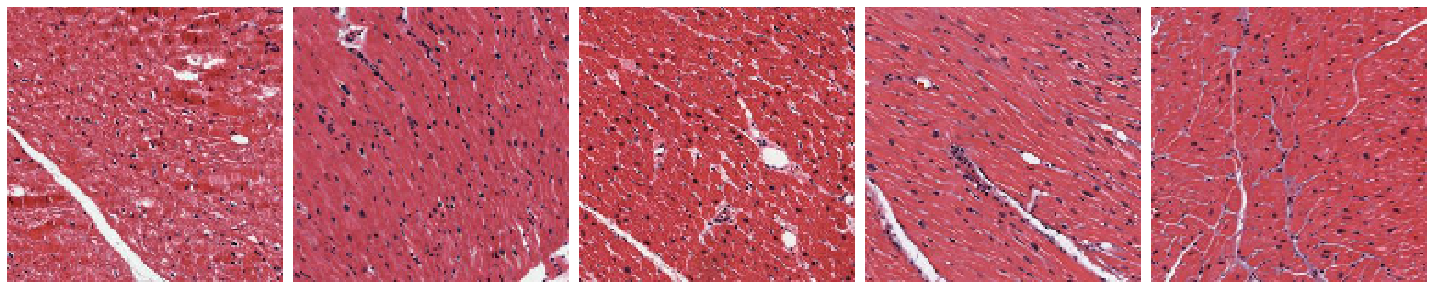

In [14]:
plotImages(sample_training_images[:5])

## Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function.

In [15]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

As all the other black magic in ML, the *ADAM* optimizer and *binary cross entropy* loss function are used here. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the model's `summary` method:

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

### Train the model

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [18]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 7 steps
Epoch 1/25
7/7 [==============================] - 39s 6s/step - loss: 1.1185 - accuracy: 0.5092 - val_loss: 0.7454 - val_accuracy: 0.5324
Epoch 2/25
7/7 [==============================] - 36s 5s/step - loss: 0.7098 - accuracy: 0.5138 - val_loss: 0.6919 - val_accuracy: 0.5324
Epoch 3/25
7/7 [==============================] - 38s 5s/step - loss: 0.6927 - accuracy: 0.5172 - val_loss: 0.6873 - val_accuracy: 0.5324
Epoch 4/25
7/7 [==============================] - 37s 5s/step - loss: 0.6833 - accuracy: 0.5206 - val_loss: 0.6744 - val_accuracy: 0.5324
Epoch 5/25
7/7 [==============================] - 37s 5s/step - loss: 0.6655 - accuracy: 0.5172 - val_loss: 0.6408 - val_accuracy: 0.5324
Epoch 6/25
7/7 [==============================] - 36s 5s/step - loss: 0.6269 - accuracy: 0.5310 - val_loss: 0.6162 - val_accuracy: 0.6462
Epoch 

### Visualize training results

Now visualize the results after training the network.

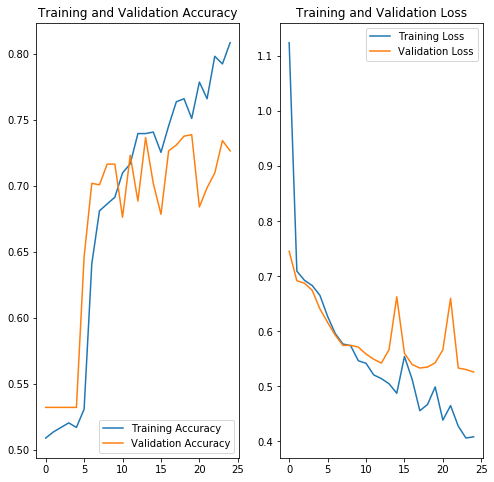

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training accuracy and validation accuracy are off by large margin and the model has achieved only around **75%** accuracy on the validation set while the training set is well on its way to **85%**. If given more epochs, the accuracy will diverge further. So does the loss.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 75% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of *overfitting*.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. The *data augmentation* and *dropout* are popular techniques to overcome that.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training examples by augmenting them with random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement this in `tf.keras` using the `ImageDataGenerator` class. Pass  different transformations to the dataset and it will take care of applying it during the training process.

### Augment and visualize data

Begin by applying random horizontal flip augmentation to the dataset and see how individual images look like after the transformation.

### Apply horizontal flip

Pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to `True` to apply this augmentation.

In [20]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [21]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1000 images belonging to 2 classes.


Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

In [22]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

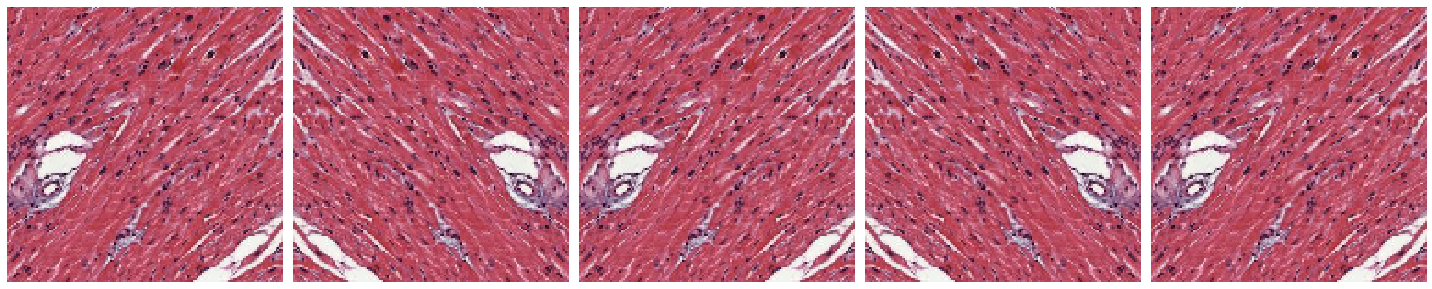

In [23]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### Randomly rotate the image

Apply 45 degrees of rotation randomly to the training samples as another augmentation.

In [24]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [25]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 1000 images belonging to 2 classes.


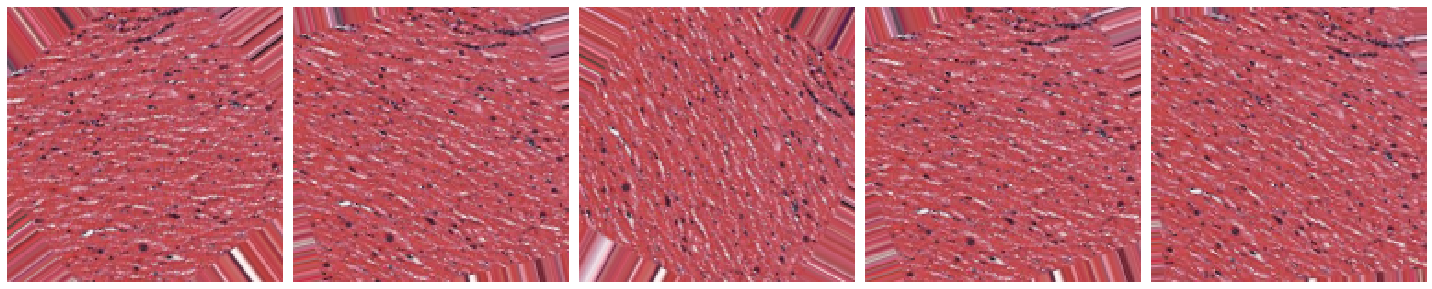

In [26]:
plotImages(augmented_images)

### Apply zoom augmentation

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [27]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [28]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 1000 images belonging to 2 classes.


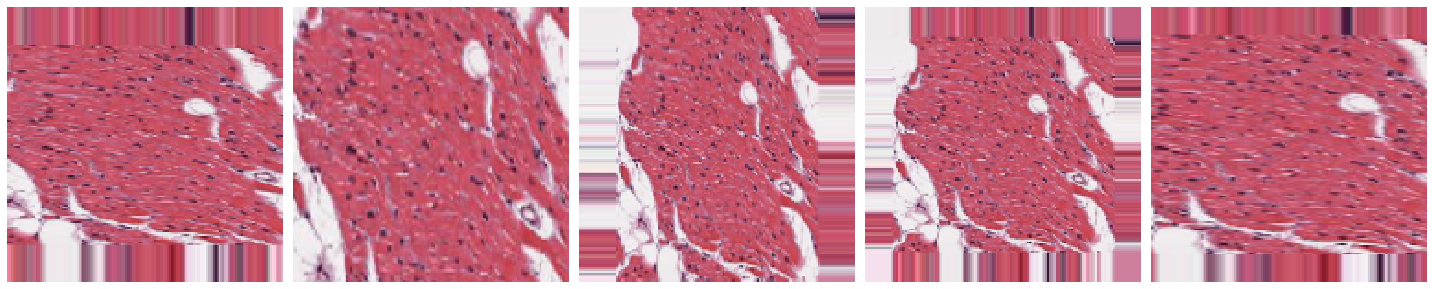

In [29]:
plotImages(augmented_images)

### Put it all together

Apply all the previous augmentations: rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [30]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [31]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 1000 images belonging to 2 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

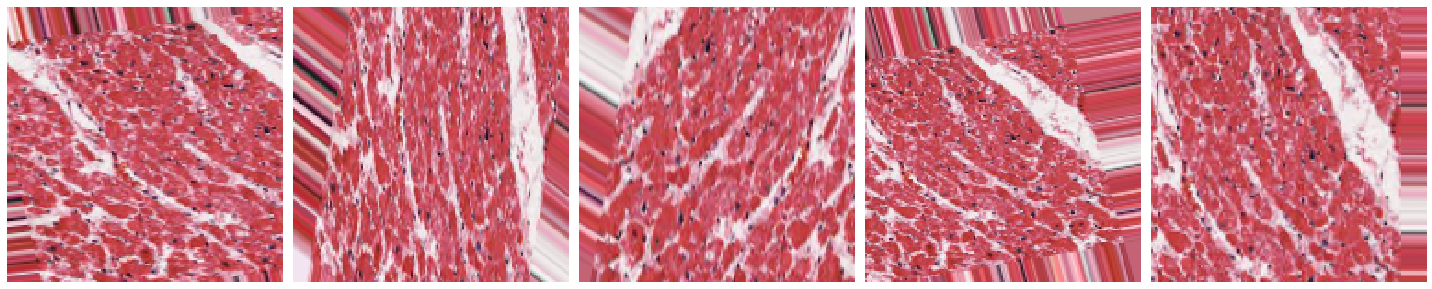

In [32]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [33]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [34]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 978 images belonging to 2 classes.


## Dropout

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in multiple ML scenarios, including image classification.

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

## Creating a new network with Dropouts

Apply dropout to first and last max pool layers. Applying dropout will randomly set 20% of the neurons to zero during each training epoch. This helps to avoid overfitting on the training dataset. And of course, it could also forget useful knowledge.

In [35]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [36]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [37]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 7 steps
Epoch 1/25
7/7 [==============================] - 48s 7s/step - loss: 2.1214 - accuracy: 0.4922 - val_loss: 0.7010 - val_accuracy: 0.5190
Epoch 2/25
7/7 [==============================] - 46s 7s/step - loss: 0.6996 - accuracy: 0.5206 - val_loss: 0.6913 - val_accuracy: 0.5190
Epoch 3/25
7/7 [==============================] - 47s 7s/step - loss: 0.6903 - accuracy: 0.5287 - val_loss: 0.6870 - val_accuracy: 0.5190
Epoch 4/25
7/7 [==============================] - 51s 7s/step - loss: 0.6890 - accuracy: 0.5179 - val_loss: 0.6657 - val_accuracy: 0.5190
Epoch 5/25
7/7 [==============================] - 45s 6s/step - loss: 0.6866 - accuracy: 0.5344 - val_loss: 0.6651 - val_accuracy: 0.5301
Epoch 6/25
7/7 [==============================] - 46s 7s/step - loss: 0.6666 - accuracy: 0.5700 - val_loss: 0.6477 - val_accuracy: 0.5324
Epoch 7/25
7/7 [==============================] - 44s 6s/step - loss: 0.6494 - acc

### Visualize the model

Visualize the new model after training. There is significantly less overfitting than before. The accuracy suffers slightly. However, there is no divergence in either accuracy or loss in training and verification data sets.

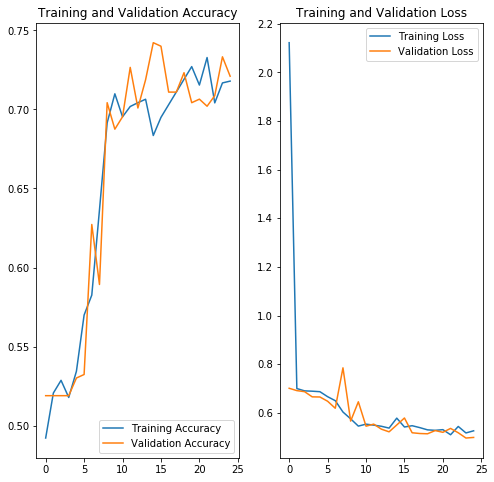

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()